# Shifted Beta-Geometric Modeling with Cohorts

In this notebook we replicate the main results and figures from ["How to Project Customer Retention"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) by Hardie & Fader (2007), which introduces the Shifted Beta-Geometric (sBG) model for customer behavior in a discrete contractual setting. It is ideal for business cases involving recurring subscriptions and has the following assumptions:
* Customer cancellation probabilities are Beta-distributed with hyperparameters `alpha` and `beta`.
* Retention rates change over time due to customer heterogeneity.
* All customers in a given cohort began their contract in the same time period.

The last assumption in particular is an ideal application for hierarchical Bayesian modeling.

# Tutorial Notebook Outstanding Tasks
- Merge PR for `expected_retention_elasticity`
- Merge Mean/Polarization index plotting PR
- Merge Static Covariate PR
- Fit regular/highend data to both a cohort and covariate model to replicate research results
- Synthesize time cohort model with covariates to showcase conventional cohort EDA, additional predictive methods, and mean/polar plotting

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Load Data and EDA
Adapt plots from sBG-Individual notebook here.

In [3]:
# TODO: Need full dataset to T=13!
dataset = pd.read_csv("https://raw.githubusercontent.com/ColtAllen/pymc-marketing/refs/heads/clv-sbg-model/data/sbg_reg_hi_cohorts.csv")
dataset.describe()

,customer_id,recency,T
count,2000.000000,2000.000000,2000.0
mean,1000.500000,4.508000,8.0
std,577.494589,2.981842,0.0
min,1.000000,1.000000,8.0
25%,500.750000,1.750000,8.0
50%,1000.500000,4.000000,8.0
75%,1500.250000,8.000000,8.0
max,2000.000000,8.000000,8.0


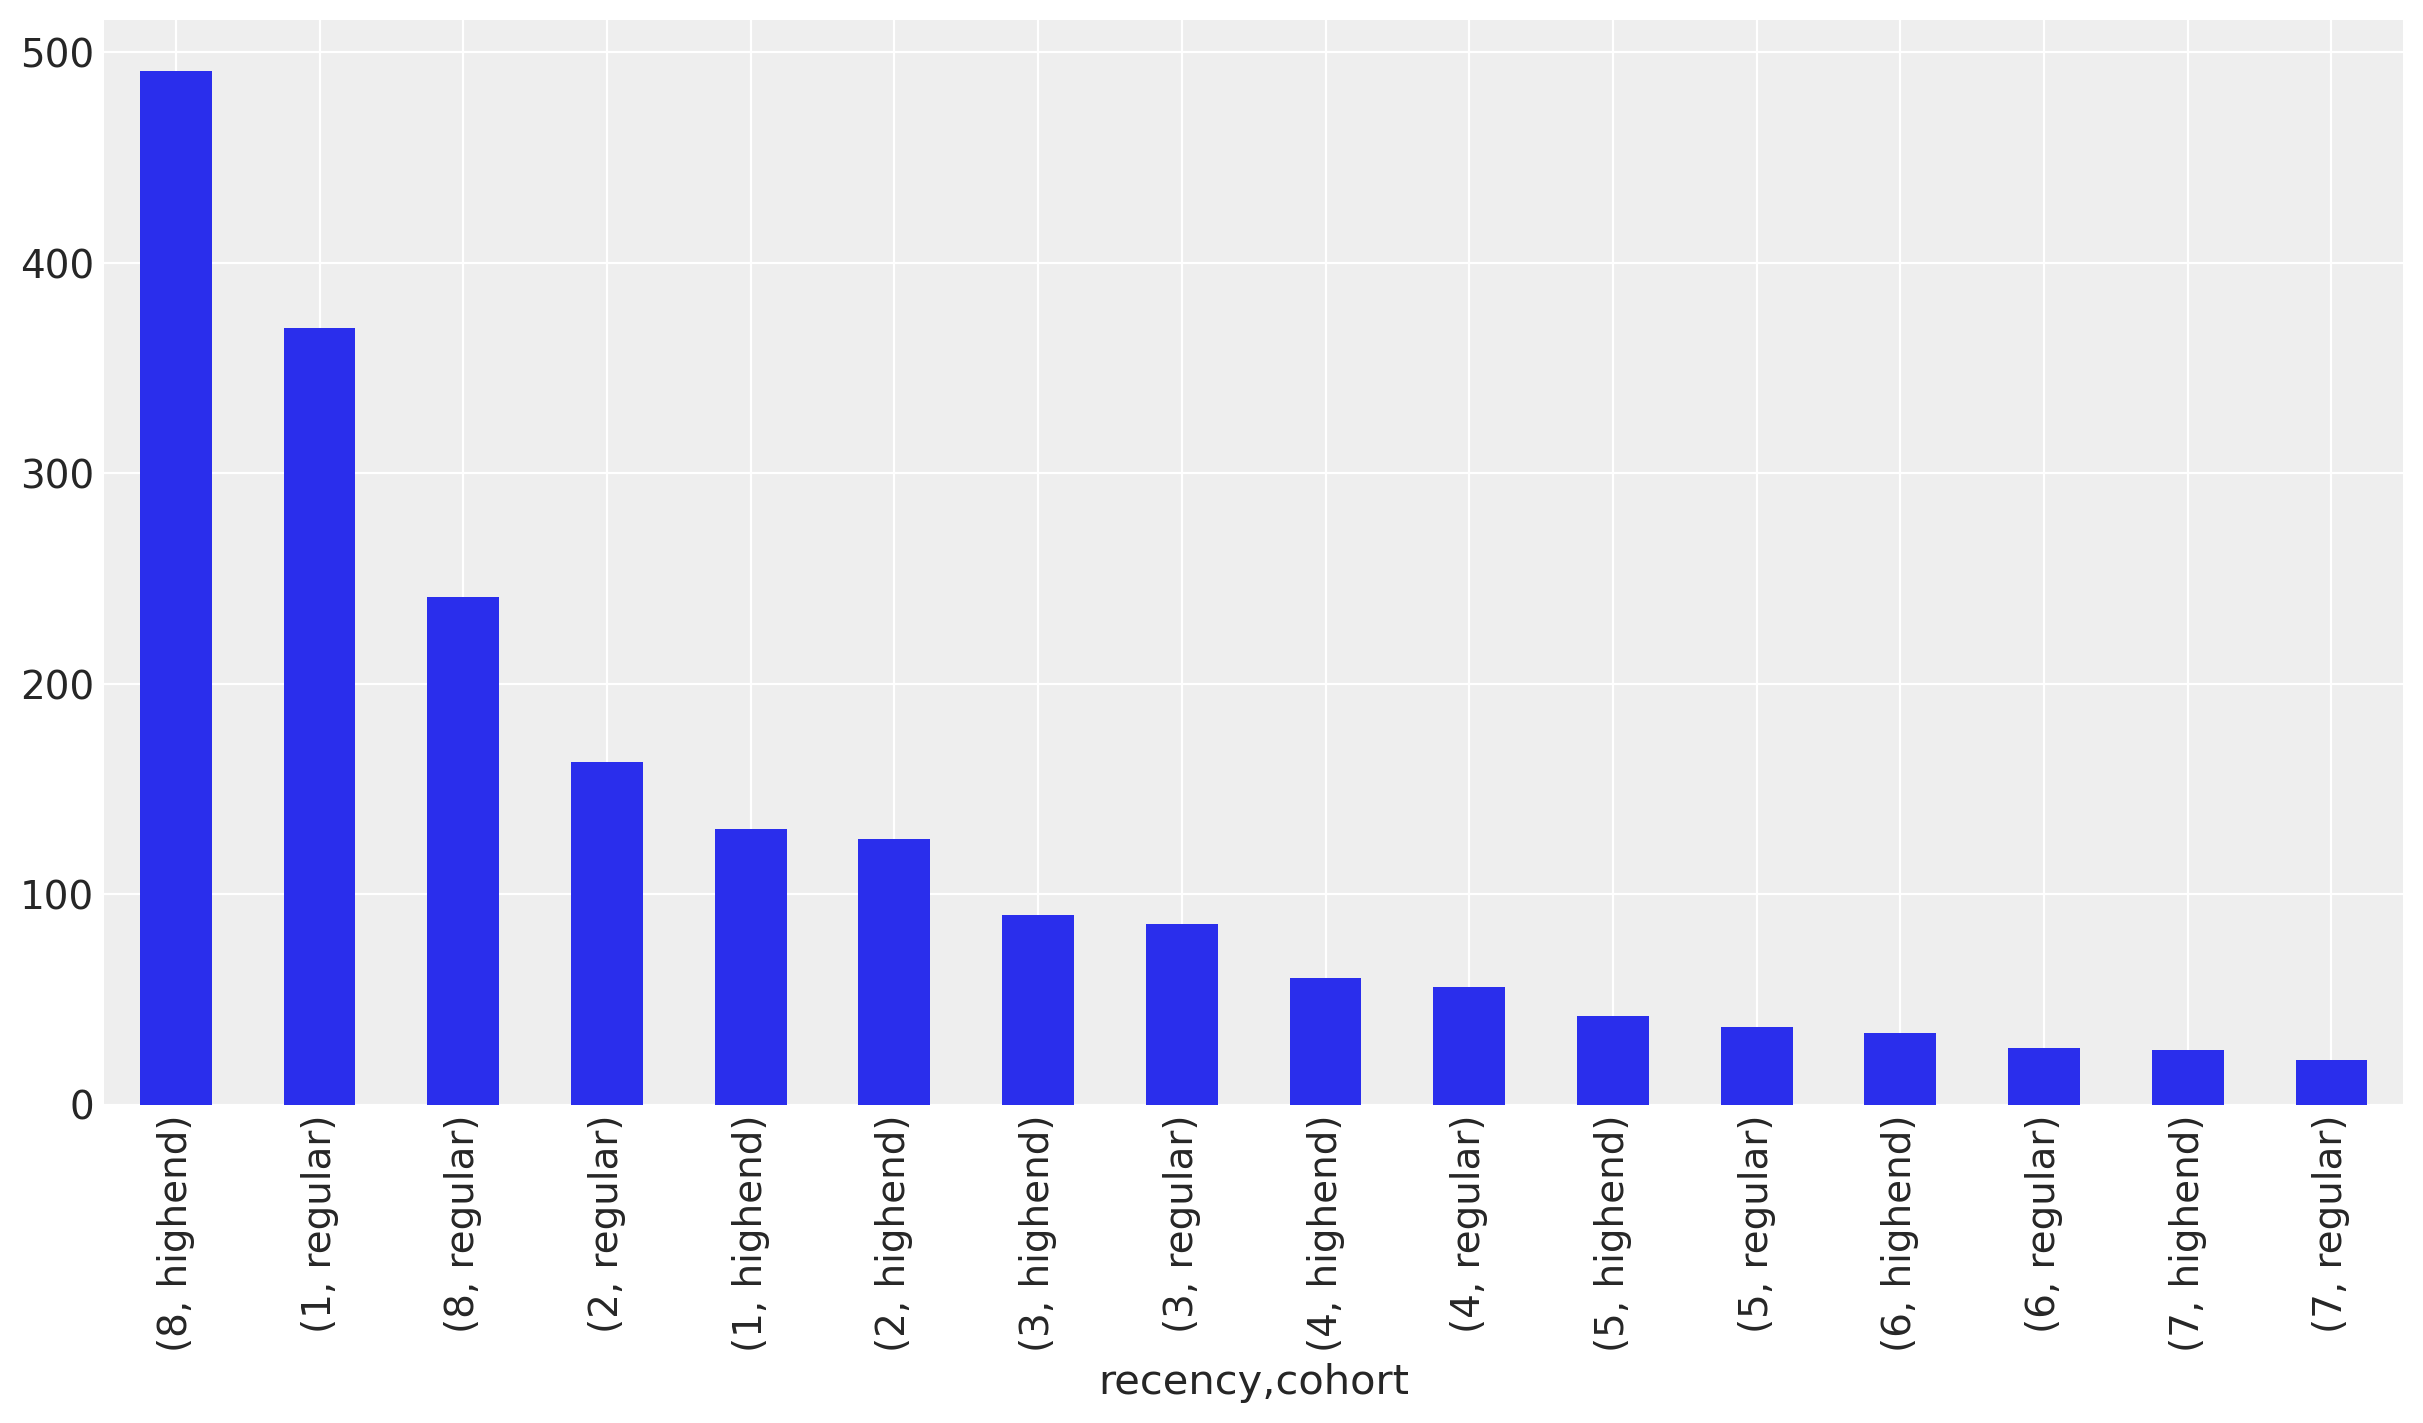

In [4]:
# Add a barplot of raw data here
dataset[["recency", "cohort"]].value_counts().plot(kind='bar');
# aggregation code to re-create data in the next cell used for the research paper
# move imported dataframe generation code into scripts/generate_data/

In [5]:
# Data from research paper
df = pd.DataFrame(
    {
        "regular": [
            100.0,
            63.1,
            46.8,
            38.2,
            32.6,
            28.9,
            26.2,
            24.1,
            22.3,
            20.7,
            19.4,
            18.3,
            17.3,
        ],
        "highend": [
            100.0,
            86.9,
            74.3,
            65.3,
            59.3,
            55.1,
            51.7,
            49.1,
            46.8,
            44.5,
            42.7,
            40.9,
            39.4,
        ],
    }
)
df

,regular,highend
0,100.0,100.0
1,63.1,86.9
2,46.8,74.3
3,38.2,65.3
4,32.6,59.3
5,28.9,55.1
6,26.2,51.7
7,24.1,49.1
8,22.3,46.8
9,20.7,44.5


Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

## Model Fitting

In [6]:
sbg = clv.ShiftedBetaGeoModel(
    data=dataset,
    model_config = {
        "alpha": Prior("HalfFlat",dims="cohort"),
        "beta": Prior("HalfFlat",dims="cohort")
    }
)
sbg.build_model()
sbg.fit(fit_method='map')
sbg.fit_summary()

Output()

alpha[highend]    0.668
alpha[regular]    0.704
beta[highend]     3.806
beta[regular]     1.182
Name: value, dtype: float64

#### Differential Evolution Metropolis
NUTS defaults to a compound sampler since this is a discrete sampling distribution. It still works great for a dataset of this size, but with large numbers of customers and cohorts, [`DEMetropolisZ`](https://www.pymc.io/projects/docs/en/v5.6.1/api/generated/pymc.DEMetropolisZ.html) may be more performant.

In [7]:
sbg = clv.ShiftedBetaGeoModel(
    data=dataset,
)
sbg.build_model()
sbg.fit(fit_method='demz',tune=3000, draws=3000) #'demz' needs a lot of tunes/draws
sbg.thin_fit_result(keep_every=2)
sbg.fit_summary(var_names=["alpha","beta"])

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [phi, kappa]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[highend],0.668,0.107,0.497,0.881,0.003,0.003,995.0,1184.0,1.01
alpha[regular],0.703,0.063,0.590,0.821,0.002,0.001,866.0,1495.0,1.01
beta[highend],3.816,0.819,2.438,5.379,0.026,0.021,1004.0,1302.0,1.00
beta[regular],1.184,0.145,0.914,1.452,0.005,0.003,914.0,1408.0,1.01


## Contrasting posterior inferences with the repo MLE estimates

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the latent churn rate distribution `theta`. 
The larger the values of `alpha` and `beta`, the more homogenous the churn rates across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

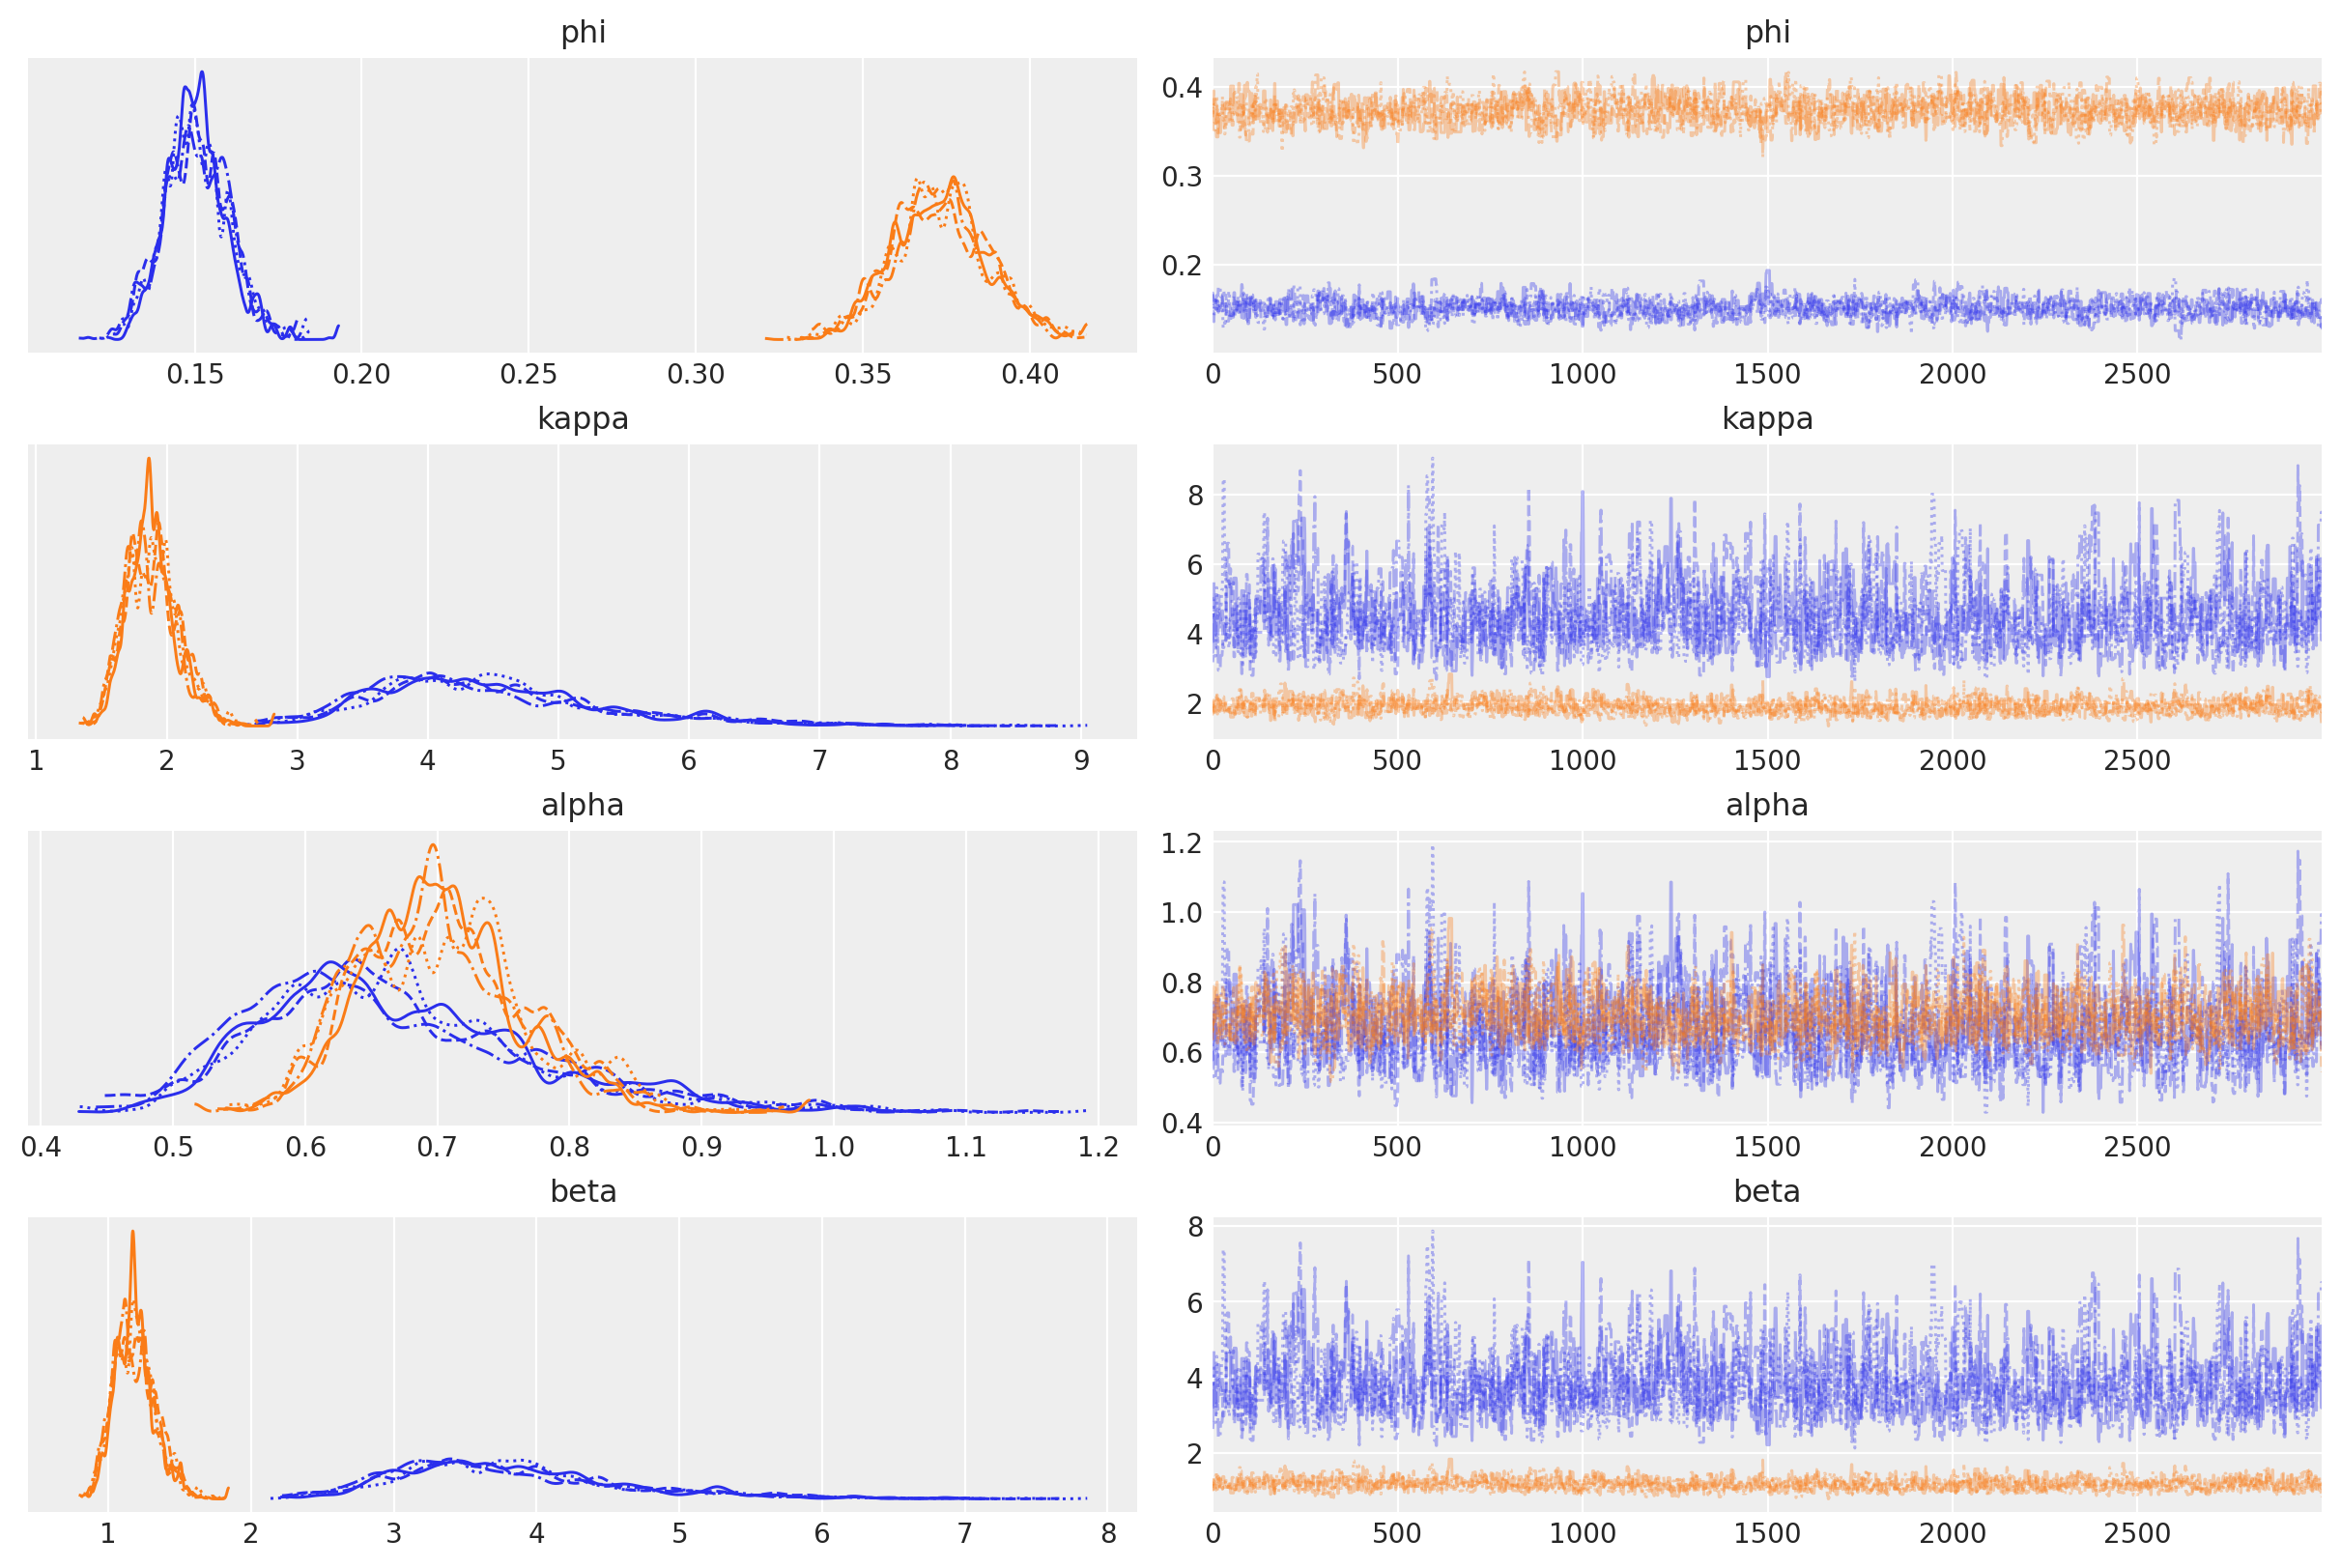

In [8]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.668, 3.806],
    "regular": [0.704, 1.182],
}
az.plot_trace(sbg.idata)

# Predictive Methods

In [9]:
pred_data=dataset.query("recency==T")
pred_cohort_retention = sbg.expected_retention_rate(pred_data,future_t=0).mean(("chain","draw"))

pred_cohort_retention.to_dataframe(name="retention").reset_index()

,cohort,customer_id,retention
0,highend,510,0.942131
1,highend,511,0.942131
2,highend,512,0.942131
3,highend,513,0.942131
4,highend,514,0.942131
...,...,...,...
727,regular,1996,0.921040
728,regular,1997,0.921040
729,regular,1998,0.921040
730,regular,1999,0.921040


In [10]:
max_T = 12
cohort_names = np.array(["regular","highend"])
cohorts_covar = np.array([0,1])
T_rng = np.arange(1,max_T+1,1)


pred_data = pd.DataFrame(
    {
        "customer_id": np.arange(1,1+max_T*2,1),
        "T": np.repeat(T_rng,len(cohort_names)),
        "cohort": np.tile(cohort_names,max_T),
        "covar_cohort": np.tile(cohorts_covar,max_T),
    }
)

# retention rate is estimated from T-1 time periods, reducing array length by 1
retention_array = pred_data.query("T <=12").copy()

sbg.expected_retention_rate(
            data=retention_array,
            future_t=0,
        )

# expected_purchases_over_time = xr.concat(
#     objs=[
#         sbg.expected_retention_rate(
#             data=time_data,
#             future_t=0,
#         )
#         for t in range(time_periods)
#     ],
#     dim="t",
# ).transpose(..., "t")

# unique_cohorts = np.unique(expected_purchases_over_time.coords["cohort"].values)

# for cohort in unique_cohorts:
#     print(expected_purchases_over_time.sel(cohort=cohort).mean("t"))

<xarray.DataArray (chain: 4, draw: 3000, cohort: 24)> Size: 2MB
array([[[0.6172223 , 0.83222819, 0.7608618 , ..., 0.95699699,
         0.9496822 , 0.95997367],
        [0.62249102, 0.8447368 , 0.75536771, ..., 0.95161584,
         0.94587576, 0.95473197],
        [0.61399021, 0.83999981, 0.75282536, ..., 0.95460399,
         0.9462275 , 0.95763826],
        ...,
        [0.61708467, 0.83958333, 0.75732884, ..., 0.95576365,
         0.94795298, 0.95875107],
        [0.61708467, 0.83958333, 0.75732884, ..., 0.95576365,
         0.94795298, 0.95875107],
        [0.61708467, 0.83958333, 0.75732884, ..., 0.95576365,
         0.94795298, 0.95875107]],

       [[0.62939942, 0.84671878, 0.75624521, ..., 0.9524289 ,
         0.94488563, 0.95549798],
        [0.62939942, 0.84671878, 0.75624521, ..., 0.9524289 ,
         0.94488563, 0.95549798],
        [0.61993522, 0.85570072, 0.75960116, ..., 0.95184686,
         0.94857551, 0.95485487],
...
        [0.60444447, 0.86566143, 0.7638295 , ..., 0.95740518,
         0.95304199, 0.96012815],
        [0.59991461, 0.8606984 , 0.76849729, ..., 0.95691867,
         0.95559695, 0.95970218],
        [0.60952636, 0.87137514, 0.77282755, ..., 0.95822443,
         0.95616235, 0.96086676]],

       [[0.6192742 , 0.85318282, 0.74340686, ..., 0.95982467,
         0.93977283, 0.96254523],
        [0.6192742 , 0.85318282, 0.74340686, ..., 0.95982467,
         0.93977283, 0.96254523],
        [0.6192742 , 0.85318282, 0.74340686, ..., 0.95982467,
         0.93977283, 0.96254523],
        ...,
        [0.61870101, 0.86753031, 0.7505917 , ..., 0.94325718,
         0.94406611, 0.9463255 ],
        [0.61870101, 0.86753031, 0.7505917 , ..., 0.94325718,
         0.94406611, 0.9463255 ],
        [0.61870101, 0.86753031, 0.7505917 , ..., 0.94325718,
         0.94406611, 0.9463255 ]]], shape=(4, 3000, 24))
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 24kB 0 1 2 3 4 5 ... 2994 2995 2996 2997 2998 2999
  * cohort       (cohort) object 192B 'regular' 'highend' ... 'highend'
    customer_id  (cohort) int64 192B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24

**Below plotting code cells were lifted directly from sBG-Individual notebook and require adaptation:**

In [ ]:
az.plot_hdi(
    weeks_,
    hi_retention.mean("customer_id"),
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"label": "high end"},
)
az.plot_hdi(
    weeks_,
    lo_retention.mean("customer_id"),
    hdi_prob=0.95,
    color="C1",
    fill_kwargs={"label": "regular"},
)

plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
plt.plot(weeks_, retention_rate_regular_obs, color="k")

plt.axvline(7, ls="--", color="k")
plt.ylim([0.5, 1.05])
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Figure 5");

In [ ]:
obs = df["highend"]/100

plt.plot(survive_pred,color="b", label="predicted")
plt.plot(obs,color="k", label="observed")
plt.ylabel("Survival Rate")
plt.legend()
plt.title("High-End Customers MAP")

plt.plot(reg_retention_cohort[:8],color="b", label="predicted")
plt.plot(retention_rate_regular_obs[:8],color="k", label="observed")
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Regular Customers MCMC Estimated with Cohorts")

# Additional Predictive Methods

Below methods are described in https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf

### Simulate Data from Follow-Up Paper
Adapt below code to create time-period cohorts with highend & regular covariate customers mixed into each.

In [11]:
import numpy as np
import pandas as pd

# Cohort table from the markdown (empty cells omitted)
# only need the params for unit testing
# alpha 3.80, beta = 15.20
cohort_counts = {
    2001: {2001: 10000, 2002: 8000, 2003: 6480, 2004: 5307, 2005: 4391},
    2002: {2002: 10000, 2003: 8000, 2004: 6480, 2005: 5307},
    2003: {2003: 10000, 2004: 8000, 2005: 6480},
    2004: {2004: 10000, 2005: 8000},
    2005: {2005: 10000},
}

# alpha=0.067, beta=0.267
case2 = {
    2003: {2003: 10000, 2004: 8000, 2005: 7600, 2006: 7383, 2007: 7235},
    2004: {2004: 10000, 2005: 8000, 2006: 7600, 2007: 7383},
    2005: {2005: 10000, 2006: 8000, 2007: 7600},
    2006: {2006: 10000, 2007: 8000},
    2007: {2007: 10000},
}
# (Bottom totals row is intentionally ignored)

rows = []
for cohort, year_counts in cohort_counts.items():
    years_sorted = sorted(year_counts)
    ages = [y - cohort for y in years_sorted]
    S = [year_counts[y] for y in years_sorted]  # survivors per age
    last_t = ages[-1]  # observation window for this cohort (right-censoring time T)

    # Churn in interval t -> t+1 (event observed at t)
    for t in range(len(S) - 1):
        count = S[t] - S[t + 1]
        if count > 0:
            rows.append({"cohort": cohort, "recency": t, "T": last_t, "count": count})

    # Right-censored at last observed age (still active)
    if S[-1] > 0:
        rows.append({"cohort": cohort, "recency": last_t, "T": last_t, "count": S[-1]})

counts_df = pd.DataFrame(rows)

# Expand to one row per customer
t_churn_array = np.repeat(counts_df["recency"].to_numpy(), counts_df["count"].to_numpy())
T_array = np.repeat(counts_df["T"].to_numpy(), counts_df["count"].to_numpy())
cohort_array = np.repeat(counts_df["cohort"].to_numpy(), counts_df["count"].to_numpy())
customer_id = np.arange(t_churn_array.size)

case_1_2_df = pd.DataFrame(
    {
        "customer_id": customer_id + 1,
        "recency": t_churn_array + 1,
        "T": T_array + 1,
        "cohort": cohort_array,
    }
).astype({"customer_id": int, "recency": int, "T": int, "cohort": str})

#df.to_csv("sbg_cohorts.csv",index=False)

In [12]:
fit_case_1_2_df = case_1_2_df.query("T>1")

sbg_case1_2 = clv.ShiftedBetaGeoModel(
    data = fit_case_1_2_df,
    model_config = {
        "alpha": Prior("HalfFlat", dims="cohort"),
        "beta": Prior("HalfFlat", dims="cohort"),
    }
)
sbg_case1_2.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

### Expected Retention Elasticity
TO BE ADDED IN NEXT PR!

In [74]:
    def expected_retention_elasticity(
        self,
        data: pd.DataFrame | None = None,
        *,
        discount_rate: float = 0.0,
    ) -> xarray.DataArray:
        """Compute expected retention elasticity.

        Adapted from equation (8) in [1]_.

        References
        ----------
        .. [1] Fader, P. S., & Hardie, B. G. (2010). Customer-Base Valuation in a Contractual Setting:
               The Perils of Ignoring Heterogeneity. Marketing Science, 29(1), 85-93.
               https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf
        """
        if data is None:
            data = self.data

        dataset = self._extract_predictive_variables(
            data, customer_varnames=["recency", "T"]
        )
        alpha = dataset["alpha"]
        beta = dataset["beta"]
        T = dataset["T"]

        retention_elasticity = hyp2f1(
            1, beta + T - 1, alpha + beta + 1, 1 / (1 + discount_rate)
        )
        # TODO: "cohorts" dim instead of "customer_id"?
        return retention_elasticity.transpose(
            "chain", "draw", "cohorts", "customer_id", missing_dims="ignore"
        )

AttributeError: 'ShiftedBetaGeoModel' object has no attribute 'expected_lifetime_purchases'

# Expected Lifetime Transactions
Add unit testing fixtures here for visual inspection

In [13]:
# TODO: Generalize and move into conftest? create_mock_fit doesn't support multi-dim parameters
def mock_cohort_fit(model, params, chains, draws, cohorts):
    """Mock a fitted model with multi-dim parameters."""
    # Generate arrays from true parameters for alpha and beta
    alpha_beta_sim = [
        np.random.normal(
            param,
            1e-3,
            size=(chains, draws, len(cohorts)),
        )
        for param in params
    ]
    # Mock posterior
    param_arrays = [
        xr.DataArray(
            param[0],
            dims=("chain", "draw", "cohort"),
            coords={
                "chain": np.arange(chains),
                "draw": np.arange(draws),
                "cohort": cohorts,
            },
            name=param[1],
        )
        for param in zip(alpha_beta_sim, ["alpha", "beta"], strict=False)
    ]
    posterior = az.convert_to_inference_data(xr.merge(param_arrays))
    # Set idata and add fit data group
    model.idata = posterior
    model.set_idata_attrs(model.idata)
    if model.data is not None:
        model._add_fit_data_group(model.data)

    return model

In [14]:
# Test parameters for expected_residual_lifetime, expected_retention_elasticity
# Both parameter sets from from pg(4) of paper: https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf
alpha_case1_case2 = [3.80, 0.067]
beta_case1_case2 = [15.20, 0.267]

# Create separate model for expected_residual_lifetime tests with case1/case2 cohorts
# Create mock data for case1/case2 cohorts (representing different renewal periods)
erl_data = pd.DataFrame(
    {
        "customer_id": np.arange(1, 11),
        "recency": np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]),
        "T": np.array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
        "cohort": np.array(
            [
                "case1",
                "case1",
                "case1",
                "case1",
                "case1",
                "case2",
                "case2",
                "case2",
                "case2",
                "case2",
            ]
        ),
    }
)
erl_model = clv.ShiftedBetaGeoModel(erl_data)
erl_model.build_model()

erl_cohorts = ["case1", "case2"]
chains = 2
draws=50

# Mock a fitted model with [case1, case2] cohort parameters
# for testing expected_residual_lifetime, expected_retention_elasticity
erl_model = mock_cohort_fit(
    erl_model,
    [alpha_case1_case2, beta_case1_case2],
    chains,
    draws,
    erl_cohorts,
)

erl_model.idata.posterior.mean(("chain","draw"))

<xarray.Dataset> Size: 72B
Dimensions:  (cohort: 2)
Coordinates:
  * cohort   (cohort) <U5 40B 'case1' 'case2'
Data variables:
    alpha    (cohort) float64 16B 3.8 0.0669
    beta     (cohort) float64 16B 15.2 0.267

In [15]:
# DERL values from Table 3, pg(5) of paper: https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf
# Case 1: alpha=3.80, beta=15.20 (high retention case)
# Case 2: alpha=0.067, beta=0.267 (low retention case)
# DERL for T=1,2,3,4,5 renewals with d=0.1 discount rate
residual_lifetime_case1_obs = np.array([3.31, 3.45, 3.59, 3.72, 3.84])
residual_lifetime_case2_obs = np.array([7.68, 9.46, 9.86, 10.06, 10.19])

prediction_targets = (residual_lifetime_case1_obs, residual_lifetime_case2_obs)

In [16]:
# Create test data for (T=1,2,3,4,5) renewals for both case1 and case2 cohorts
n_periods = 5
cohort_names = np.array(["case1", "case2"])
T_rng = np.arange(1, n_periods + 1, 1)

erl_test_data = pd.DataFrame(
    {
        "customer_id": np.arange(1, 1 + n_periods * 2, 1),
        "T": np.repeat(T_rng, len(cohort_names)),
        "cohort": np.tile(cohort_names, n_periods),
    }
)

erl_test_data

,customer_id,T,cohort
0,1,1,case1
1,2,1,case2
2,3,2,case1
3,4,2,case2
4,5,3,case1
5,6,3,case2
6,7,4,case1
7,8,4,case2
8,9,5,case1
9,10,5,case2


In [17]:
erl_data

,customer_id,recency,T,cohort
0,1,1,5,case1
1,2,2,5,case1
2,3,3,5,case1
3,4,4,5,case1
4,5,5,5,case1
5,6,1,5,case2
6,7,2,5,case2
7,8,3,5,case2
8,9,4,5,case2
9,10,5,5,case2


In [18]:
def test_expected_residual_lifetime(prediction_targets, erl_test_data):
    """Test expected_residual_lifetime against Table 3 values from the paper."""
    # Extract observed residual lifetime data arrays by cohort
    residual_lifetime_case1_obs, residual_lifetime_case2_obs = prediction_targets

    # Run full predictions with discount_rate=0.1 (as used in paper Table 3)
    expected_residual_lifetime_cohorts = erl_model.expected_residual_lifetime(
        erl_test_data,
        discount_rate=0.1,
    ).mean(("chain", "draw"))

    # Extract predictions by cohort
    expected_residual_lifetime_case1 = expected_residual_lifetime_cohorts.sel(
        cohort="case1"
    ).values
    expected_residual_lifetime_case2 = expected_residual_lifetime_cohorts.sel(
        cohort="case2"
    ).values

    # Compare against paper values (Table 3, pg 5)
    np.testing.assert_allclose(
        expected_residual_lifetime_case1, residual_lifetime_case1_obs, rtol=0.05
    )
    np.testing.assert_allclose(
        expected_residual_lifetime_case2, residual_lifetime_case2_obs, rtol=0.05
    )

test_expected_residual_lifetime(prediction_targets, erl_test_data)

In [19]:
n_periods = 5
cohort_names = np.array(["case1", "case2"])
T_rng = np.arange(1, n_periods + 1, 1)

erl_test_data = pd.DataFrame(
    {
        "customer_id": np.arange(1, 1 + n_periods * 2, 1),
        "T": np.repeat(T_rng, len(cohort_names)),
        "cohort": np.tile(cohort_names, n_periods),
    }
)

erl_test_data

erl_model.expected_residual_lifetime(erl_test_data,discount_rate=0.1)

<xarray.DataArray (chain: 2, draw: 50, cohort: 10)> Size: 8kB
array([[[ 3.30963718,  7.68207419,  3.45081902,  9.4646033 ,
          3.58636242,  9.85816141,  3.71663048, 10.06233234,
          3.84195324, 10.19401531],
        [ 3.31030435,  7.69722379,  3.45149457,  9.47058397,
          3.5870452 ,  9.86256837,  3.71731947, 10.06594806,
          3.84264753, 10.19712533],
        [ 3.30857133,  7.77096562,  3.44974152,  9.50832092,
          3.58527494,  9.89119996,  3.71553454, 10.08970445,
          3.84085019, 10.2176833 ],
        [ 3.30968482,  7.6511446 ,  3.45086045,  9.44079503,
          3.5863981 ,  9.83948752,  3.71666086, 10.04664328,
          3.84197871, 10.18034687],
        [ 3.311161  ,  7.70147017,  3.45235998,  9.4747855 ,
          3.58791805,  9.86590791,  3.7181986 , 10.06876694,
          3.8435319 , 10.1995871 ],
        [ 3.30943803,  7.69687029,  3.45061554,  9.47522615,
          3.58615509,  9.86644934,  3.71641975, 10.06928136,
          3.8417395 , 10.20006261],
        [ 3.30898234,  7.70017396,  3.45014426,  9.47324613,
          3.58566981,  9.86467459,  3.71592191, 10.06772298,
...
          3.58679364,  9.85647788,  3.71706277, 10.06080977,
          3.84238624, 10.19263911],
        [ 3.30988679,  7.61574866,  3.45106499,  9.42574582,
          3.58660487,  9.8282912 ,  3.71686953, 10.0374213 ,
          3.84218902, 10.17239736],
        [ 3.31031707,  7.58295316,  3.45151823,  9.4053509 ,
          3.58707888,  9.81252487,  3.71736235, 10.02424314,
          3.84269888, 10.16094698],
        [ 3.30922469,  7.68675495,  3.45039991,  9.4628361 ,
          3.58593751,  9.85650893,  3.71620052, 10.06086287,
          3.84151889, 10.19269781],
        [ 3.30977276,  7.6333576 ,  3.45095687,  9.43882675,
          3.58650226,  9.83853063,  3.71677206, 10.04601851,
          3.84209634, 10.17988504],
        [ 3.30951254,  7.72342226,  3.45068501,  9.48499838,
          3.58621989,  9.87358164,  3.7164802 , 10.07511067,
          3.84179592, 10.20506596],
        [ 3.3084949 ,  7.6475256 ,  3.44966241,  9.43831313,
          3.58519345,  9.83755507,  3.7154509 , 10.04502393,
          3.84076462, 10.17893798]]])
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * cohort       (cohort) object 80B 'case1' 'case2' 'case1' ... 'case1' 'case2'
    customer_id  (cohort) int64 80B 1 2 3 4 5 6 7 8 9 10

### Latent Dropout Distribution for Customer Population
Distribution mean and polarization index plotting will be added in future PR rather than visualizations of the latent cohort dropout distributions, but for illustratrive examples in tutorial notebook, latent distribution plotting code is provided below:

In [ ]:
alpha_fit = sbg.fit_result["alpha"]
beta_fit = sbg.fit_result["beta"]

rng = np.random.default_rng(42)
theta_sim = rng.beta(alpha_fit,beta_fit)

theta = xr.DataArray(
    theta_sim,
    dims=("chains","draws","cohort"),
    coords={
        "chains": np.arange(4), 
        "draws": np.arange(1000),
        "cohort": ["highend","regular"],
    },
    name="theta",
)

az_theta = az.convert_to_inference_data(theta)

highend = az_theta.sel(cohort="highend")
highend
highend.posterior["theta"].values.flatten()

az.plot_dist(highend.posterior["theta"].values.flatten())

az_theta.mean(("chains","draws"))

# plot this by cohort
theta
az.plot_dist(theta)

In [ ]:
# Map cohort-wise [alpha, beta] refs to ArviZ variable labels
ref_val_map = {}
for cohort, (a_ref, b_ref) in ref_val.items():
    ref_val_map[f"alpha\n{cohort}"] = a_ref
    ref_val_map[f"beta\n{cohort}"]  = b_ref
   
az.plot_posterior(
    idata,  # InferenceData; uses the posterior group by default
    var_names=["alpha", "beta"],
    ref_val=ref_val_map,
)

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Mon Oct 20 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

matplotlib    : 3.10.3
arviz         : 0.22.0
pymc          : 5.25.1
pytensor      : 2.31.7
pandas        : 2.3.1
numpy         : 2.2.6
pymc_extras   : 0.4.0
xarray        : 2025.7.1
pymc_marketing: 0.15.1

Watermark: 2.5.0

